In [6]:
import sys
#print(sys.path)
sys.path.append(r'C:\Users\T.PRANEETH\YAFS\src')
import yafs
import warnings
warnings.filterwarnings('ignore')

## Topology :

* It is the actual network devices at edge, fog and cloud levels and the connections between them

* The network devices are represented as nodes with features such as, **IPT**, **RAM**, **COST** and **POWER**

* The links on the other hand are represented by edges with features such as, **BandWidth**, **PropogationSpeed**


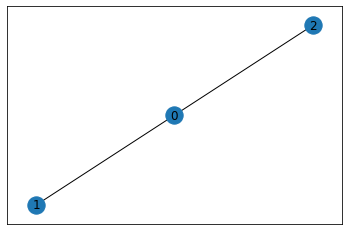

In [7]:
from yafs.topology import Topology
import networkx as nx

topology_json = {}
topology_json["entity"] = []
topology_json["link"] = []

cloud_dev    = {"id": 0, "model": "cloud","mytag":"cloud", "IPT": 5000 * 10 ^ 6, "RAM": 40000,"COST": 3,"WATT":20.0}
sensor_dev   = {"id": 1, "model": "sensor-device", "IPT": 100* 10 ^ 6, "RAM": 4000,"COST": 3,"WATT":40.0}
actuator_dev = {"id": 2, "model": "actuator-device", "IPT": 100 * 10 ^ 6, "RAM": 4000,"COST": 3, "WATT": 40.0}

link1 = {"s": 0, "d": 1, "BW": 1, "PR": 10}
link2 = {"s": 0, "d": 2, "BW": 1, "PR": 1}

topology_json["entity"].append(cloud_dev)
topology_json["entity"].append(sensor_dev)
topology_json["entity"].append(actuator_dev)
topology_json["link"].append(link1)
topology_json["link"].append(link2)

t = Topology()
t.load(topology_json)
nx.draw_networkx(t.G)

## Application :

* Application is represented in a way similar to a Data Flow Diagram which is also a graph, but directed and acyclic

* Its nodes represent the **sensor(input)**, **actuator(output)**, **collection of modules**

* Its edges represent the **messages(flow of data)** from one service module to another

In [8]:
import random
from yafs.application import Application
from yafs.application import Message
from yafs.application import fractional_selectivity


def create_application(appname):
    
        
    # APLICATION
    a = Application(name=appname)
    
    # (S) --> (ServiceA) --> (A)
    a.set_modules([{"Sensor":{"Type":Application.TYPE_SOURCE}},
                   {"ServiceA": {"RAM": 10, "Type": Application.TYPE_MODULE}},
                   {"Actuator": {"Type": Application.TYPE_SINK}}
                   ])
    """
    Messages among MODULES (AppEdge in iFogSim)
    """
    m_a = Message("M.A", "Sensor", "ServiceA", instructions=20*10^6, bytes=1000)
    m_b = Message("M.B", "ServiceA", "Actuator", instructions=30*10^6, bytes=500)
    
    print(m_a)
    """
    Defining which messages will be dynamically generated # the generation is controlled by Population algorithm
    """
    a.add_source_messages(m_a)

    """
    MODULES/SERVICES: Definition of Generators and Consumers (AppEdges and TupleMappings in iFogSim)
    """
    # MODULE SERVICES
    a.add_service_module("ServiceA", m_a, m_b, fractional_selectivity, threshold=1.0)

    return a

app1 = create_application("Tutorial1")
print(app1)

{--
 Name: M.A (-1)
 From (src): Sensor  to (dst): ServiceA
 --}

___ APP. Name: Tutorial1
 __ Transmissions 
	Module: None : M_In: Sensor  -> M_Out: ServiceA 
	 ServiceA
		 M_In: M.A  -> M_Out: M.B 



In [9]:
from yafs.population import Statical
def deterministicDistribution(time_shift):
    return time_shift
pop = Statical("Statical")
pop.set_src_control({"model": "sensor-device", "number":1,"message": app1.get_message("M.A"), "distribution": deterministicDistribution,"param": {"time_shift": 100}})#5.1}})
pop.set_sink_control({"model": "actuator-device","number":1,"module":app1.get_sink_modules()})

In [10]:
from yafs import Selection
class MinimumPath(Selection):

    def get_path(self, sim, app_name, message, topology_src, alloc_DES, alloc_module, traffic):
        """
        Computes the minimun path among the source elemento of the topology and the localizations of the module

        Return the path and the identifier of the module deployed in the last element of that path
        """
        node_src = topology_src
        DES_dst = alloc_module[app_name][message.dst]

        print("GET PATH")
        print("\tNode _ src (id_topology): %i" %node_src)
        print("\tRequest service: %s " %message.dst)
        print("\tProcess serving that service: %s " %DES_dst)

        bestPath = []
        bestDES = []

        for des in DES_dst: ## In this case, there are only one deployment
            dst_node = alloc_DES[des]
            print("\t\t Looking the path to id_node: %i" %dst_node)

            path = list(nx.shortest_path(sim.topology.G, source=node_src, target=dst_node))

            bestPath = [path]
            bestDES = [des]

        return bestPath, bestDES

selectorPath = MinimumPath()

In [11]:
from yafs.placement import Placement

class CloudPlacement(Placement):

    def initial_allocation(self, sim, app_name):
    #We find the ID-nodo/resource 
        value = {"mytag": "cloud"} # or whatever tag
        id_cluster = sim.topology.find_IDs(value)
        app = sim.apps[app_name]
        services = app.services

        for module in services:
            if module in self.scaleServices:
                for rep in range(0, self.scaleServices[module]):
                    idDES = sim.deploy_module(app_name,module,services[module],id_cluster)
placement = CloudPlacement("onCloud") # it defines the deployed rules: module-device
placement.scaleService({"ServiceA": 1})

In [16]:
from yafs import Sim
s = Sim(t) # t is the topology
simulation_time = 100000
s.deploy_app(app1, placement, selectorPath)
s.run(simulation_time)

----------------------------------------
DES	| TOPO 	| Src.Mod 	| Modules
----------------------------------------
0 	| 0 	| -- 		| ServiceA
----------------------------------------


2022-12-21 11:58:13,043 - root - INFO - Running experiment it: - 0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 11, 13, 14, 15, 16, 17, 18, 20, 24, 19, 21, 22, 23, 25, 26, 28, 27, 29, 30, 31]
2022-12-21 11:58:13,200 - root - INFO -  Performing simulation: 0 
----------------------------------------
DES	| TOPO 	| Src.Mod 	| Modules
----------------------------------------
0 	| 1 	| M.USER.APP.0 		| --
1 	| 2 	| M.USER.APP.1 		| --
2 	| 3 	| M.USER.APP.2 		| --
3 	| 4 	| M.USER.APP.3 		| --
4 	| 0 	| -- 		| 0_01
5 	| 0 	| -- 		| 1_01
6 	| 0 	| -- 		| 2_01
7 	| 0 	| -- 		| 3_01
8 	| 0 	| -- 		| 4_01
9 	| 0 	| -- 		| 5_01
10 	| 0 	| -- 		| 6_01
----------------------------------------
----------------------------------------
DES	| TOPO 	| Src.Mod 	| Modules
----------------------------------------
0 	| 1 	| M.USER.APP.0 		| --
1 	| 2 	| M.USER.APP.1 		| --
2 	| 3 	| M.USER.APP.2 		| --
3 	| 4 	| M.USER.APP.3 		| --
4 	| 0 	| -- 		| 0_01
5 	| 0 	| -- 		| 1_01
6 	| 0 	| -- 		| 2_01
7 	| 0 	| -- 		

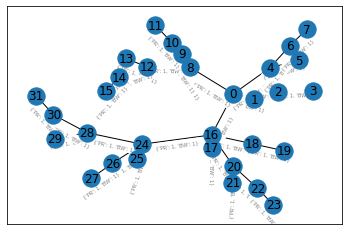

In [1]:
"""
    This is basic topology, with some users and a set of apps with only one service.

    @author: Isaac Lera
"""

import os
import time
import json
import random
import logging.config

import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from yafs.core import Sim
from yafs.application import create_applications_from_json
from yafs.topology import Topology

from yafs.placement import JSONPlacement
from yafs.path_routing import DeviceSpeedAwareRouting
from yafs.distribution import deterministic_distribution




def main(stop_time, it,folder_results):

    """
    TOPOLOGY
    """
    t = Topology()

    # You also can create a topology using JSONs files. Check out examples folder
    size = 5
    t.G = nx.generators.binomial_tree(size) # In NX-lib there are a lot of Graphs generators

    # Definition of mandatory attributes of a Topology
    ## Attr. on edges
    # PR and BW are 1 unit
    attPR_BW = {x: 1 for x in t.G.edges()}
    nx.set_edge_attributes(t.G, name="PR", values=attPR_BW)
    nx.set_edge_attributes(t.G, name="BW", values=attPR_BW)
    ## Attr. on nodes
    # IPT
    attIPT = {x: 100 for x in t.G.nodes()}
    nx.set_node_attributes(t.G, name="IPT", values=attIPT)

    nx.write_gexf(t.G,folder_results+"graph_binomial_tree_%i.gexf"%size) # you can export the Graph in multiples format to view in tools like Gephi, and so on.

    print(t.G.nodes()) # nodes id can be str or int

    # Plotting the graph
    pos=nx.spring_layout(t.G)
    nx.draw_networkx(t.G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(t.G, pos,alpha=0.5,font_size=5,verticalalignment="top")


    """
    APPLICATION or SERVICES
    """
    dataApp = json.load(open('data/appDefinition.json'))
    apps = create_applications_from_json(dataApp)

    """
    SERVICE PLACEMENT 
    """
    placementJson = json.load(open('data/allocDefinition.json'))
    placement = JSONPlacement(name="Placement", json=placementJson)

    """
    Defining ROUTING algorithm to define how path messages in the topology among modules
    """
    selectorPath = DeviceSpeedAwareRouting()

    """
    SIMULATION ENGINE
    """
    s = Sim(t, default_results_path=folder_results+"sim_trace")

    """
    Deploy services == APP's modules
    """
    for aName in apps.keys():
        s.deploy_app(apps[aName], placement, selectorPath) # Note: each app can have a different routing algorithm

    """
    Deploy users
    """
    userJSON = json.load(open('data/usersDefinition.json'))
    for user in userJSON["sources"]:
        app_name = user["app"]
        app = s.apps[app_name]
        msg = app.get_message(user["message"])
        node = user["id_resource"]
        dist = deterministic_distribution(100, name="Deterministic")
        idDES = s.deploy_source(app_name, id_node=node, msg=msg, distribution=dist)

    """
    RUNNING - last step
    """
    logging.info(" Performing simulation: %i " % it)
    s.run(stop_time)  # To test deployments put test_initial_deploy a TRUE
    s.print_debug_assignaments()


if __name__ == '__main__':
    LOGGING_CONFIG =  './logging.ini'
    logging.config.fileConfig(LOGGING_CONFIG)

    folder_results = Path("results/")
    folder_results.mkdir(parents=True, exist_ok=True)
    folder_results = str(folder_results)+"/"

    nIterations = 1  # iteration for each experiment
    simulationDuration = 20000  

    # Iteration for each experiment changing the seed of randoms
    for iteration in range(nIterations):
        random.seed(iteration)
        logging.info("Running experiment it: - %i" % iteration)

        start_time = time.time()
        main(stop_time=simulationDuration,
             it=iteration,folder_results=folder_results)

        print("\n--- %s seconds ---" % (time.time() - start_time))

    print("Simulation Done!")
  
    # Analysing the results. 
    dfl = pd.read_csv(folder_results+"sim_trace"+"_link.csv")
    print("Number of total messages between nodes: %i"%len(dfl))

    df = pd.read_csv(folder_results+"sim_trace.csv")
    print("Number of requests handled by deployed services: %i"%len(df))

    dfapp2 = df[df.app == 2].copy() # a new df with the requests handled by app 2
    print(dfapp2.head())
    
    dfapp2.loc[:,"transmission_time"] = dfapp2.time_emit - dfapp2.time_reception # Transmission time
    dfapp2.loc[:,"service_time"] = dfapp2.time_out - dfapp2.time_in

    print("The average service time of app2 is: %0.3f "%dfapp2["service_time"].mean())

    print("The app2 is deployed in the folling nodes: %s"%np.unique(dfapp2["TOPO.dst"]))
    print("The number of instances of App2 deployed is: %s"%np.unique(dfapp2["DES.dst"]))